In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("out/2019-07-27-conv2d.parquet")
print(len(df))

df["h_nelement"] = df["h.shape[0]"] * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"] * df["x.shape[1]"]
df["log10(fft_time/direct_time)"] = np.log10(df.fft_time / df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.head()

300


,direct_time,fft_time,h.shape[0],h.shape[1],mode,random_state,x.shape[0],x.shape[1],h_nelement,x_nelement,log10(fft_time/direct_time),fft_time/direct_time
0,0.000014,0.000449,3,3,full,0,3,3,9,9,1.494049,31.192428
1,0.000016,0.000424,4,4,full,1,3,3,16,9,1.413727,25.925469
2,0.000021,0.000432,6,6,full,2,3,3,36,9,1.317441,20.770221
3,0.000029,0.000438,9,9,full,3,3,3,81,9,1.174806,14.955682
4,0.000050,0.000444,14,14,full,4,3,3,196,9,0.950395,8.920626


Text(0.5, 1, 'valid')

Text(0.5, 1, 'same')

Text(0.5, 1, 'full')

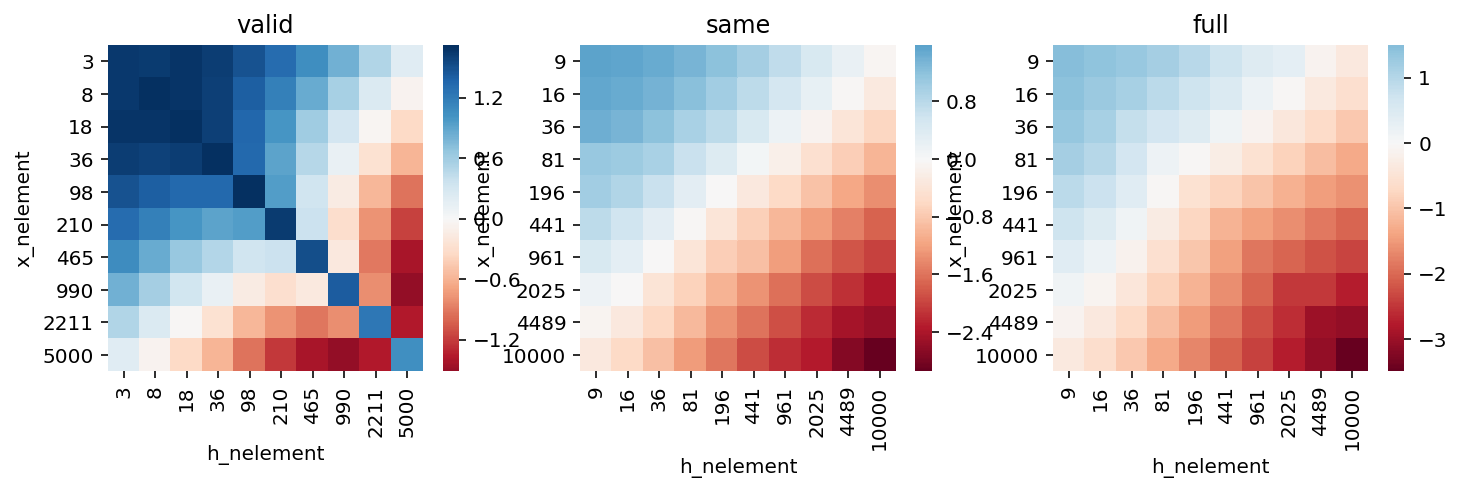

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log10(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

In [4]:
from scipy.optimize import curve_fit

def log_time(shapes, O):
    """
    Inputs
    ------
    sizes : array-like. x.shape[1] == 4
        Sizes. If convolving two arrays of size (m, n) and (a, b),
        sizes[0] == [m, n, a, b]
    
    >>> x = rand(m, n)
    >>> assert x.shape == (m, n)
    >>> h = rand(a, b)
    >>> assert h.shape == (a, b)
    >>> sizes = [[m, n, a, b], ...]
    """
    x_shape = shapes[:, [0, 1]]
    h_shape = shapes[:, [2, 3]]
    out_shape = {'full': [n + k - 1 for n, k in zip(x_shape, h_shape)],
                 'same': [n if n[0] > k[0] else k
                              for n, k in zip(x_shape, h_shape)],
                 'valid': [n-k+1 if n[0] > k[0] else k-n+1
                              for n, k in zip(x_shape, h_shape)]}
    out_shape = np.array(out_shape[mode])
    shapes = np.hstack((x_shape, h_shape, out_shape)).T
    
    direct_time = np.product(shapes, axis=0)
    fft_time = np.sum(shapes * np.log(shapes), axis=0)
    return np.log10(O * fft_time / direct_time)

def get_constant(df, mode="full"):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log10(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "x.shape[1]", "h.shape[0]", "h.shape[0]"]].values
    times = df["log10(fft_time/direct_time)"].values

    popt, pcov = curve_fit(log_time, shapes, times)
    return popt.item(), np.sqrt(pcov).item()

In [5]:
bigOs = {}
for mode in ["same", "valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    O, std = get_constant(df[idx])
    bigOs[mode] = {"constant": O, "std": std}

/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
/Users/scott/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
constants = pd.DataFrame(bigOs).T

In [8]:
constants

,constant,std
same,81261.988432,1.044320e+04
valid,1.000000,inf
full,64347.407399,7.356725e+03


In [9]:
constants["std"] / constants["constant"]

same     0.128513
valid         inf
full     0.114328
dtype: float64